# Project 2


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

from termcolor import colored
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import torchvision

from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

/home/vm/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the dataset CIFAR10

We are told to classify birds from cats in the CIFAR10 dataset. This means that we will only use the images that are labeled as birds or cats. In the CIFAR10 these labels are 2 and 3 respectively. We will have the training, validation and test datasets.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


#### Filtering by cats and birds

In [3]:
def filter_by_bids_and_cats(trainset):
    trainset.targets = torch.tensor(trainset.targets)    # Convert targets to tensor if not already

    mask = (trainset.targets == 2) | (trainset.targets == 3)     # Create mask to filter birds (label 2) and cats (label 3)
    
    trainset.targets = (trainset.targets[mask] - 2)     # Adjust labels to be 0 for birds and 1 for cats
    
    trainset.data = trainset.data[mask.numpy().astype(bool)] # Filter data and targets based on the mask
    
    return trainset


In [4]:
trainset = filter_by_bids_and_cats(trainset)
testset = filter_by_bids_and_cats(testset)

#### Splitting the training into train and valid (80/20)

In [5]:
# Define the size of the validation set
validation_size = 0.2  # 20% of the training set

# Split the training set into training subset and validation set
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(validation_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_subset = Subset(trainset, train_indices)
val_set = Subset(trainset, val_indices)

In [6]:
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
# shuffle= True as we want the training to be loaded in a random order
# num_workers=2 means that we use 2 sub-processes to load the data

validloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64,shuffle=False, num_workers=2)
# shuffle= False as we want our evaluation results to be in order, consisten. 


#### Check Splitting Sizes

In [7]:
print('Size of the original trainset:', len(trainset))

print('Size of the training set:', len(train_subset))
print('Size of the validation set:', len(val_set))
print('Size of the testing set:', len(testset))

#i want to see the first 10 rows
dataiter = iter(validloader)
images, labels = next(dataiter)
print("Images shape: ",images.shape) # this is the shape of the image

# [64, 3, 32, 32] 64 images, 3 channels, 32x32 pixels

Size of the original trainset: 10000
Size of the training set: 8000
Size of the validation set: 2000
Size of the testing set: 2000
Images shape:  torch.Size([64, 3, 32, 32])


#### Checking that our input data are birds and cats 

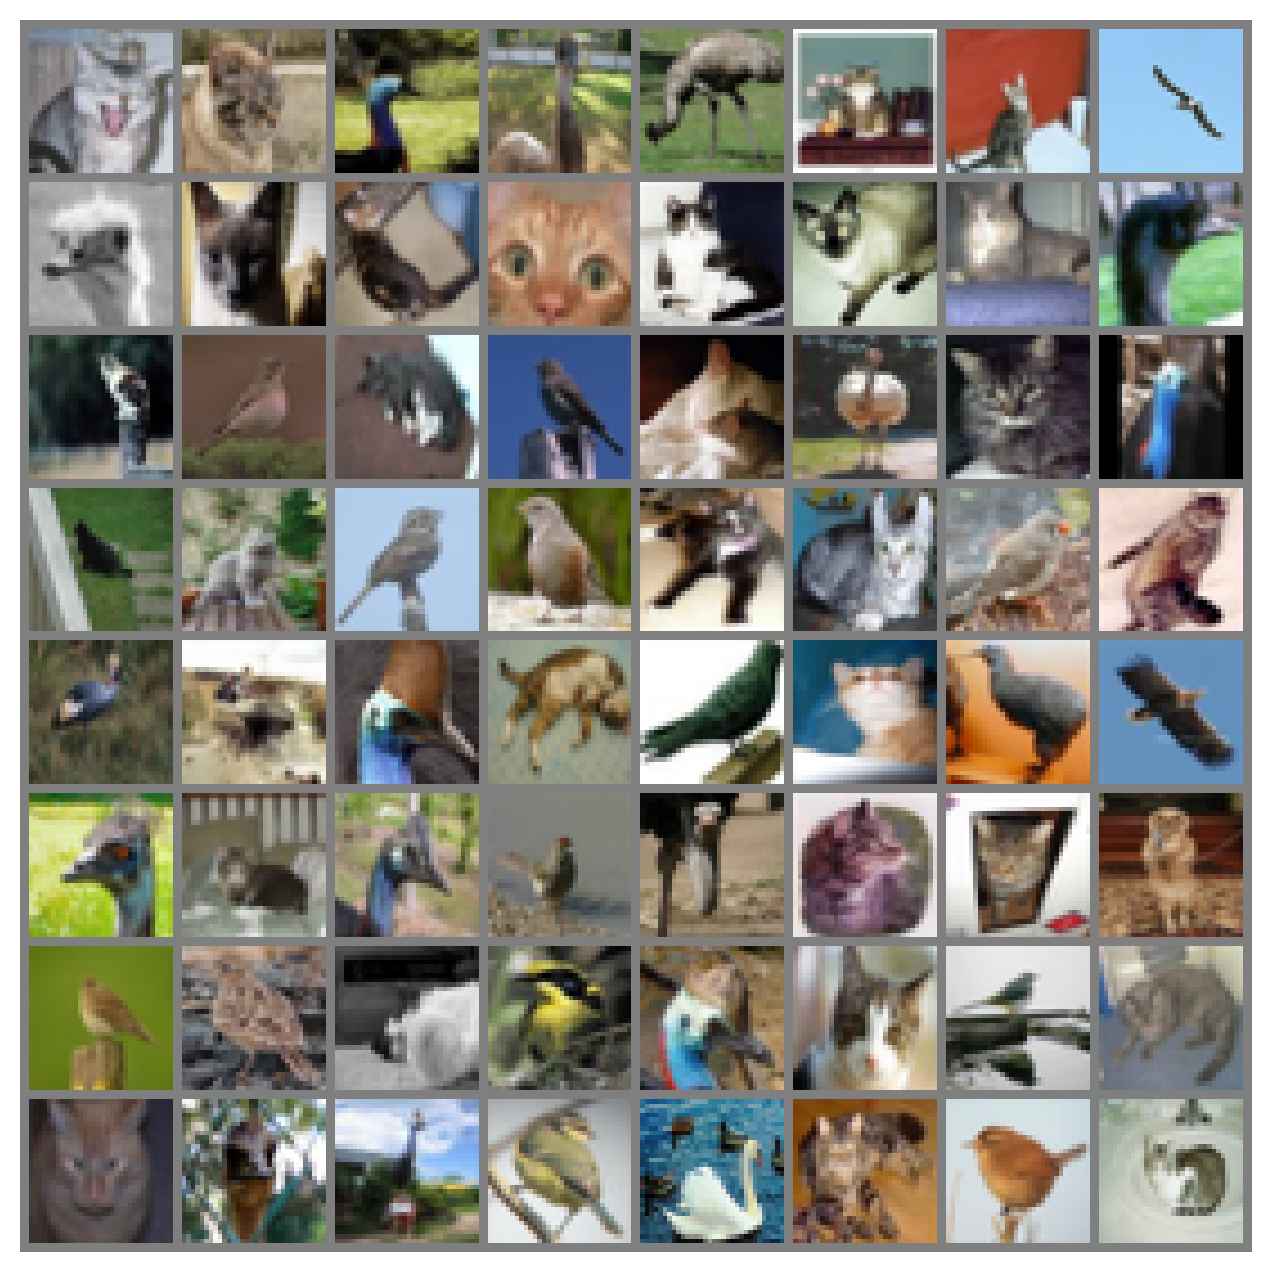

In [8]:
# Define function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))  # Adjust the figure size here
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest') 
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images))

## Implementation of a Lenet5

In [9]:
class Lenet5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)
                #print(torch.exp(outputs))
                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [10]:
model = Lenet5()
model.trainloop(trainloader,validloader,25)


Switching to GPU
Epoch 1. Training loss: 0.591110, Validation loss: 0.513053, Time per epoch: 1.741391 seconds
Epoch 2. Training loss: 0.493001, Validation loss: 0.475479, Time per epoch: 1.373666 seconds
Epoch 3. Training loss: 0.463751, Validation loss: 0.470952, Time per epoch: 1.307658 seconds
Epoch 4. Training loss: 0.437529, Validation loss: 0.460714, Time per epoch: 1.190503 seconds
Epoch 5. Training loss: 0.421847, Validation loss: 0.459178, Time per epoch: 1.346579 seconds
Epoch 6. Training loss: 0.397660, Validation loss: 0.438871, Time per epoch: 1.286980 seconds
Epoch 7. Training loss: 0.381686, Validation loss: 0.441608, Time per epoch: 1.289495 seconds
Epoch 8. Training loss: 0.365447, Validation loss: 0.443579, Time per epoch: 1.549034 seconds
Epoch 9. Training loss: 0.344553, Validation loss: 0.447322, Time per epoch: 1.443955 seconds
Epoch 10. Training loss: 0.334270, Validation loss: 0.447575, Time per epoch: 1.212998 seconds
Epoch 11. Training loss: 0.309463, Validat

8 epochs for early stopping

## Computing the Calibration Curve

In [11]:
from sklearn.calibration import calibration_curve

def compute_predicted_probabilities(val_indices, model, validloader):
    # First we select the true labels of the test data
    # true_labels = validloader.dataset.targets.numpy()
    true_labels = [trainset.targets[idx] for idx in val_indices]

    # The store the output value of the model for each image in the test set
    accuracy, outputs = model.compute_accuracy(validloader)
    outputs_cpu = [output.cpu().numpy() for output in outputs] # ALEJO: I added this line to move the tensors to the CPU
    outputs = np.concatenate(outputs_cpu) # concatenate the list of tensors into a single tensor

    # Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
    predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

    print(colored('\n============= First 50 Predicted Probabilites =============', 'green'))
    print(predicted_prob[0:50])

    print(colored('\n============= Maximum Predicted Probability =============', 'green'))
    print(max(predicted_prob))
    print(colored('\n============= Minimum Predicted Probability =============', 'green'))
    print(min(predicted_prob))

    print(colored('\n============= Accuracy =============', 'green'))
    print(accuracy)

    return true_labels, predicted_prob, accuracy


def compute_calibration_curve(true_labels, predicted_prob):

    prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)

    print(colored('\n============= True labels =============', 'green'))
    print(prob_true)

    print(colored('\n============= Predicted Probabilities =============', 'green'))
    print(prob_pred)

    # Plot calibration curve
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.grid(True)
    plt.show()
    

    return prob_true, prob_pred

In [12]:
true_labels, predicted_prob, accuracy_lenet5 = compute_predicted_probabilities(val_indices, model, validloader)


============= First 50 Predicted Probabilites =============
[0.99959904, 0.001191039, 6.53806e-06, 3.7722039e-06, 0.97795814, 0.99999934, 0.99999976, 5.851015e-11, 0.11171949, 0.9991451, 0.9999244, 0.99915165, 1.0, 0.00031535534, 0.9999999, 8.311922e-06, 0.9802433, 0.019076422, 0.97765183, 2.0174957e-05, 0.8532334, 0.0017522406, 0.9990099, 1.04422725e-05, 2.0184885e-05, 0.5940279, 5.6693055e-09, 0.92127854, 0.91089267, 0.99254435, 0.99778503, 0.9999982, 5.1463998e-05, 0.27990836, 0.00029129436, 0.9999973, 0.00022807575, 0.99999964, 0.9507973, 0.99768674, 5.116784e-08, 0.99785644, 0.0026244174, 0.0007000082, 1.0, 0.99971724, 0.999998, 0.99998385, 0.0066301613, 0.99427176]

============= Maximum Predicted Probability =============
1.0

============= Minimum Predicted Probability =============
3.8938253e-19

============= Accuracy =============
0.7905



============= True labels =============
[0.11966988 0.44594595 0.3        0.27586207 0.46428571 0.51851852
 0.42857143 0.48571429 0.51724138 0.79608651]

============= Predicted Probabilities =============
[0.00839212 0.14062308 0.25018492 0.34942938 0.4431251  0.54053229
 0.65211511 0.75030005 0.85223927 0.99214164]


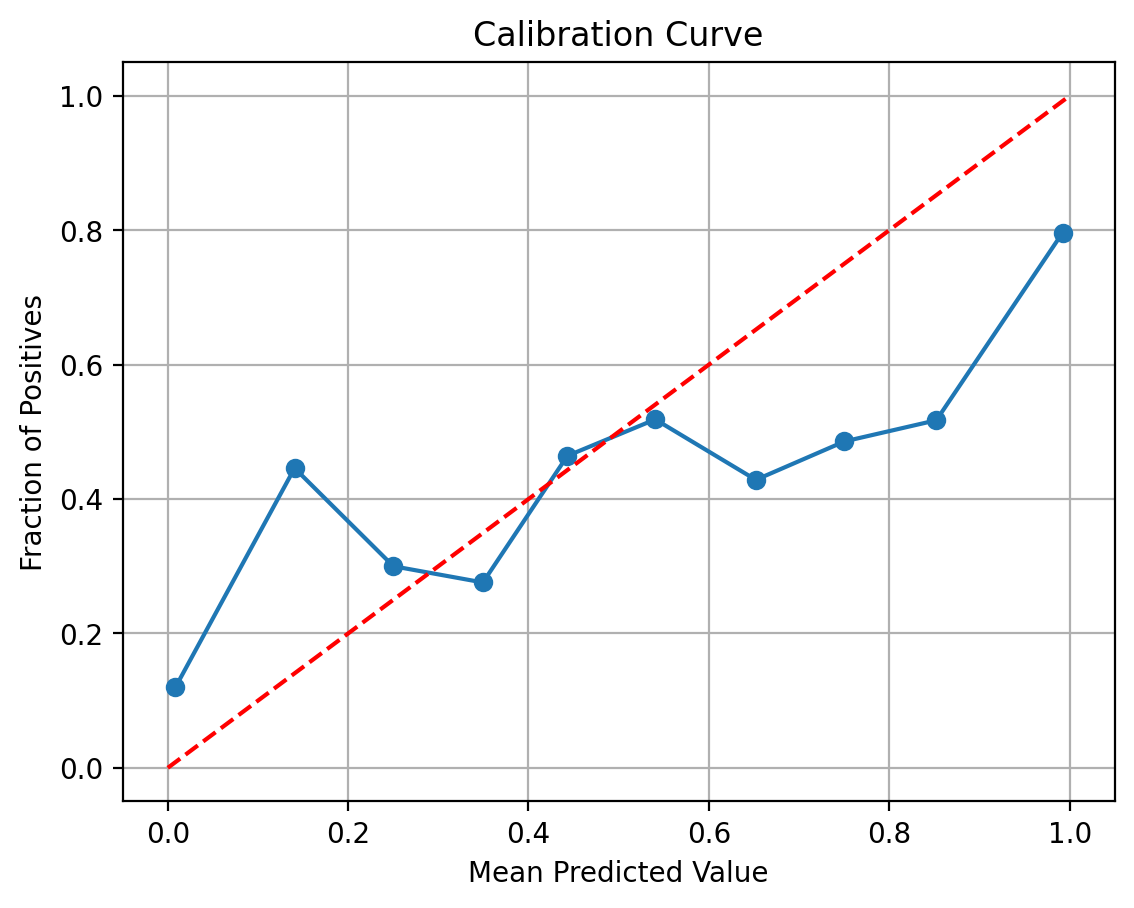

In [13]:
prob_true, prob_pred = compute_calibration_curve(true_labels, predicted_prob)

In [14]:
def computeECE(true_labels, prob_true, prob_pred):
    
    n = len(true_labels)  # Total number of samples
    M = len(prob_true)  # Number of bins
    samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

    # Compute ECE
    ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

    print(colored('\n============= Expected Calibration Error (ECE) =============', 'green'))
    print(f"{ece:.4f}")

    return ece

In [15]:
ece_lenet5 = computeECE(true_labels, prob_true, prob_pred)


============= Expected Calibration Error (ECE) =============
0.1602


#### Lenet5 regularized


In [16]:
class Lenet5_regularized(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [17]:
model = Lenet5_regularized()
model.trainloop(trainloader,validloader,8)

Switching to GPU
Epoch 1. Training loss: 0.630697, Validation loss: 0.539184, Time per epoch: 1.714667 seconds
Epoch 2. Training loss: 0.515200, Validation loss: 0.491819, Time per epoch: 1.492230 seconds
Epoch 3. Training loss: 0.487947, Validation loss: 0.473172, Time per epoch: 1.412009 seconds
Epoch 4. Training loss: 0.469906, Validation loss: 0.465713, Time per epoch: 1.463143 seconds
Epoch 5. Training loss: 0.446623, Validation loss: 0.504391, Time per epoch: 1.471242 seconds
Epoch 6. Training loss: 0.433637, Validation loss: 0.456952, Time per epoch: 1.357574 seconds
Epoch 7. Training loss: 0.411636, Validation loss: 0.449221, Time per epoch: 1.412539 seconds
Epoch 8. Training loss: 0.399411, Validation loss: 0.454737, Time per epoch: 1.567946 seconds


In [18]:
true_labels, predicted_prob, accuracy_lenet5_regu = compute_predicted_probabilities(val_indices, model, validloader)


============= First 50 Predicted Probabilites =============
[0.9189524, 0.32447356, 0.020313649, 0.07549211, 0.037160903, 0.6993916, 0.92643166, 0.00071465306, 0.5203334, 0.80345017, 0.84534717, 0.7324425, 0.92906797, 0.69224435, 0.77958685, 0.29436502, 0.36007208, 0.52135694, 0.696996, 0.05352387, 0.8196324, 0.35774827, 0.7698532, 0.0054149088, 0.33261472, 0.12383988, 0.0052503943, 0.25763062, 0.5535258, 0.92424995, 0.30829608, 0.4888932, 0.018673431, 0.22909099, 0.19980541, 0.2430413, 0.12069981, 0.9313117, 0.81558007, 0.22823118, 0.016183808, 0.49515924, 0.046327896, 0.18999796, 0.572953, 0.86318743, 0.90454614, 0.7319399, 0.030674612, 0.8608766]

============= Maximum Predicted Probability =============
0.99827456

============= Minimum Predicted Probability =============
8.23654e-06

============= Accuracy =============
0.7825



============= True labels =============
[0.07021792 0.20229008 0.26       0.42307692 0.63478261 0.55454545
 0.65942029 0.8        0.87121212 0.95081967]

============= Predicted Probabilities =============
[0.04434567 0.14665092 0.24793684 0.34578714 0.44723708 0.54710161
 0.66035734 0.75630012 0.85193344 0.94117882]


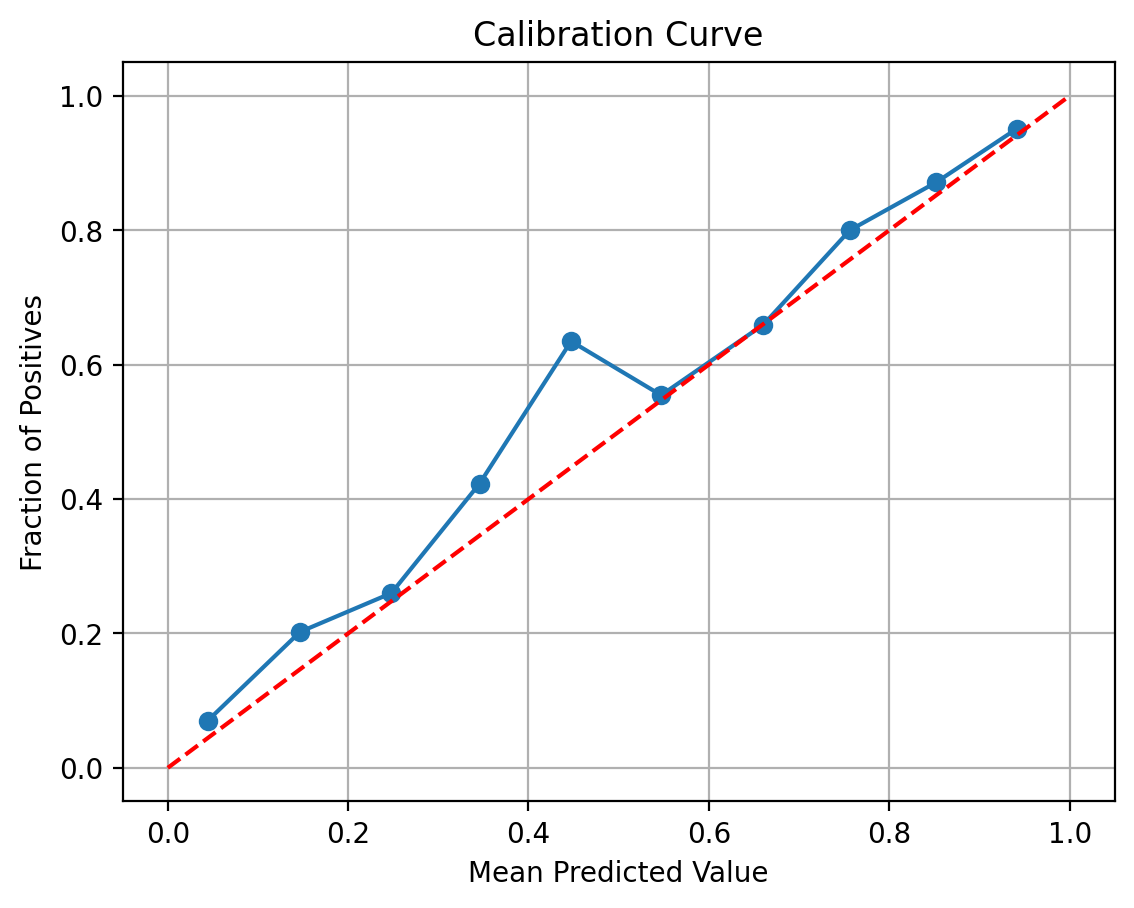

In [19]:
prob_true, prob_pred = compute_calibration_curve(true_labels, predicted_prob)

In [20]:
ece_lenet5_regu = computeECE(true_labels, prob_true, prob_pred)


============= Expected Calibration Error (ECE) =============
0.0439


# Platt scaling

For Platt scaling we have to enter our outputs (the ones obtained for the true class) multiplied by a constant a into a new sigmoid

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]



In [22]:
def compute_plat_accuracy(platt_scaled_probs, true_labels, threshold= 0.5):
    # Compute accuracy
    platt_scaled_predictions = np.where(platt_scaled_probs > threshold, 1, 0)

    # Calculate accuracy
    platt_scaled_accuracy = np.mean(platt_scaled_predictions == true_labels)

    print(colored('\n============= Accuracy after Platt scaling (Confidence=%f) =============' % threshold, 'green'))
    print(platt_scaled_accuracy)

    return platt_scaled_accuracy

In [23]:
accuracy_lenet5_regu_plat_05 = compute_plat_accuracy(platt_scaled_probs, true_labels, threshold=0.5)


============= Accuracy after Platt scaling (Confidence=0.500000) =============
0.7905


In [24]:
accuracy_lenet5_regu_plat_075 = compute_plat_accuracy(platt_scaled_probs, true_labels, threshold=0.75)


============= Accuracy after Platt scaling (Confidence=0.750000) =============
0.765



============= True labels =============
[0.02684564 0.14430894 0.25862069 0.36521739 0.59574468 0.57731959
 0.64556962 0.6547619  0.85644769 0.9321267 ]

============= Predicted Probabilities =============
[0.09221544 0.13858742 0.24228214 0.3439318  0.44713622 0.55272698
 0.65164698 0.75834502 0.85604288 0.91857305]


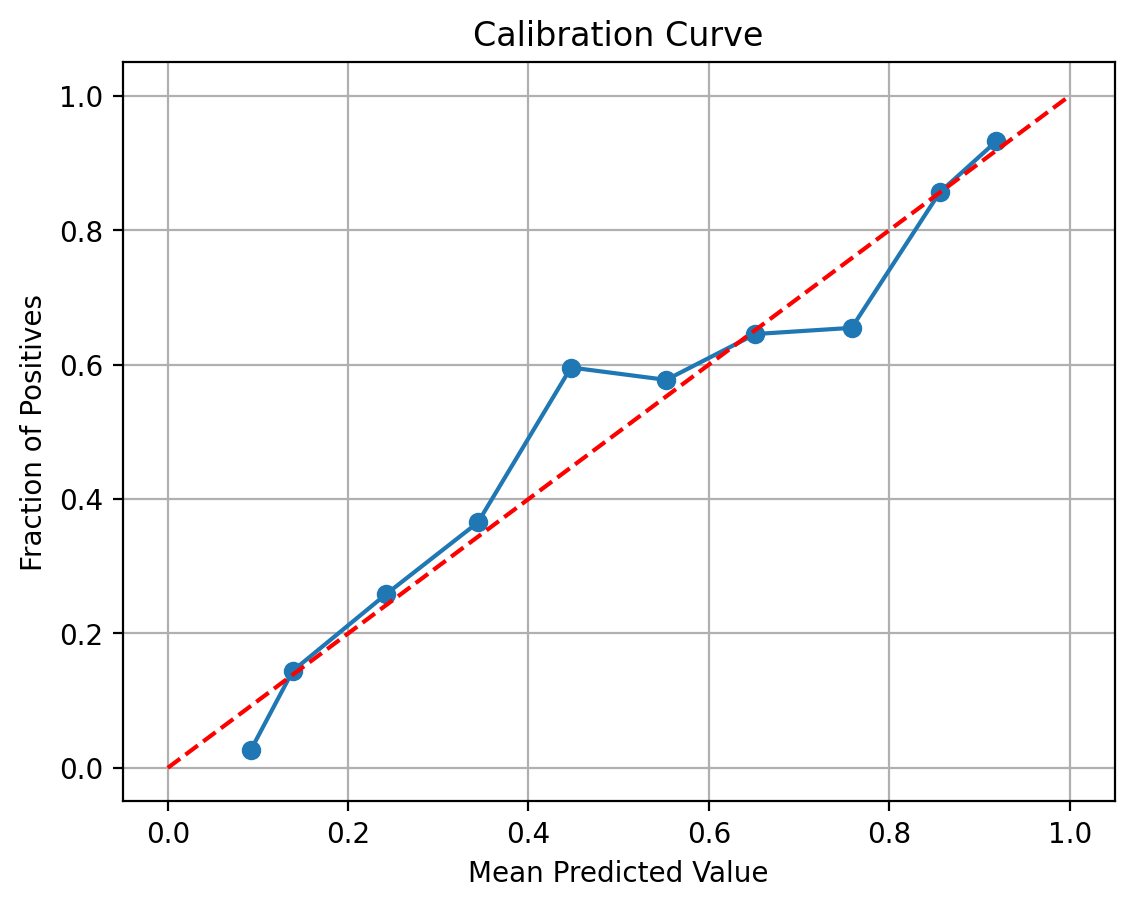

In [25]:
prob_true, prob_pred = compute_calibration_curve(true_labels, platt_scaled_probs)

In [26]:
ece_lenet5_regu_plat= computeECE(true_labels, prob_true, prob_pred)


============= Expected Calibration Error (ECE) =============
0.0406


# Optional part

We will use a pre-trained model, in this case, the DenseNet

In [27]:
from torchvision import models
model = models.densenet121(pretrained=True)

/home/vm/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vm/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We will change the classifier part of the DenseNet by the one we have also used in Lenet5 for the classification part


In [28]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.classify = nn.Sequential(
            nn.Linear(1024, 120), # The input dimension at the classifier is 1024, see DenseNet
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classify(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [29]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = Classifier()

model.classifier = classifier

Switching to GPU


Class for training the new model

In [30]:
class Tran_Eval():


    def __init__(self,model,maxiter=30,lr=0.001):

        self.model = model

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)

        self.max_iter = maxiter

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")
                
        self.model.to(self.device)

    def trainloop(self,trainloader):

        # Optimization Loop

        it_images = iter(trainloader)

        running_loss = 0.

        self.model.train()

        for e in range(int(self.max_iter)):

            start_time = time.time()

            images,labels = next(it_images)


            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)

            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.model.forward(images) #YOUR CODE HERE

            loss = self.criterion(out,labels) #YOUR CODE HERE

            running_loss = loss.item()

            #Your code here
            loss.backward()

            #Your code here
            self.optim.step()

            self.loss_during_training.append(running_loss)

            print('Epoch %d of %d finished. Loss %f, Time per epoch: %f seconds' 
                  %(e+1,self.max_iter,running_loss,
                       (time.time() - start_time)))


    def compute_accuracy(self,model, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.model.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model.forward(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list

In [31]:
model_with_train = Tran_Eval(model,maxiter=10)

Switching to GPU


In [32]:
model_with_train.trainloop(trainloader)

Epoch 1 of 10 finished. Loss 0.677888, Time per epoch: 0.235465 seconds
Epoch 2 of 10 finished. Loss 0.707140, Time per epoch: 0.043865 seconds
Epoch 3 of 10 finished. Loss 0.692665, Time per epoch: 0.054806 seconds
Epoch 4 of 10 finished. Loss 0.707258, Time per epoch: 0.053890 seconds
Epoch 5 of 10 finished. Loss 0.692243, Time per epoch: 0.042044 seconds
Epoch 6 of 10 finished. Loss 0.676242, Time per epoch: 0.044574 seconds
Epoch 7 of 10 finished. Loss 0.665378, Time per epoch: 0.047635 seconds
Epoch 8 of 10 finished. Loss 0.658644, Time per epoch: 0.054306 seconds
Epoch 9 of 10 finished. Loss 0.620278, Time per epoch: 0.053501 seconds
Epoch 10 of 10 finished. Loss 0.676629, Time per epoch: 0.049063 seconds


In [33]:
def compute_predicted_probabilities(val_indices, model, validloader):
    # First we select the true labels of the test data
    # true_labels = validloader.dataset.targets.numpy()
    true_labels = [trainset.targets[idx] for idx in val_indices]

    # The store the output value of the model for each image in the test set
    accuracy, outputs = model_with_train.compute_accuracy(model, validloader)
    outputs_cpu = [output.cpu().numpy() for output in outputs] # ALEJO: I added this line to move the tensors to the CPU
    outputs = np.concatenate(outputs_cpu) # concatenate the list of tensors into a single tensor

    # Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
    predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

    print(colored('\n============= First 50 Predicted Probabilites =============', 'green'))
    print(predicted_prob[0:50])

    print(colored('\n============= Maximum Predicted Probability =============', 'green'))
    print(max(predicted_prob))
    print(colored('\n============= Minimum Predicted Probability =============', 'green'))
    print(min(predicted_prob))


    print(colored('\n============= Accuracy =============', 'green'))
    print(accuracy)
    
    return true_labels, predicted_prob, accuracy

In [34]:
true_labels, predicted_prob, accuracy_densenet = compute_predicted_probabilities(val_indices, model, validloader)


============= First 50 Predicted Probabilites =============
[0.507306, 0.46298757, 0.42352402, 0.42789248, 0.4041679, 0.5142629, 0.5499492, 0.4350819, 0.44816583, 0.47330967, 0.50785035, 0.53550625, 0.4631518, 0.5038223, 0.48444095, 0.39237118, 0.53326154, 0.4250537, 0.50285053, 0.41582158, 0.61102504, 0.4704972, 0.5310537, 0.5260625, 0.33997753, 0.48168135, 0.46321753, 0.39455345, 0.58173174, 0.5090012, 0.49576494, 0.46173084, 0.4178488, 0.5023208, 0.47594115, 0.49036017, 0.4146188, 0.47371104, 0.5057542, 0.40257436, 0.39550304, 0.47458535, 0.3853564, 0.46057618, 0.4867641, 0.48036668, 0.5569904, 0.52038926, 0.42052272, 0.49492913]

============= Maximum Predicted Probability =============
0.6967707

============= Minimum Predicted Probability =============
0.3125806

============= Accuracy =============
0.7585



============= True labels =============
[0.04195804 0.32313231 0.83426966 1.        ]

============= Predicted Probabilities =============
[0.37865758 0.45602166 0.53201847 0.62349591]


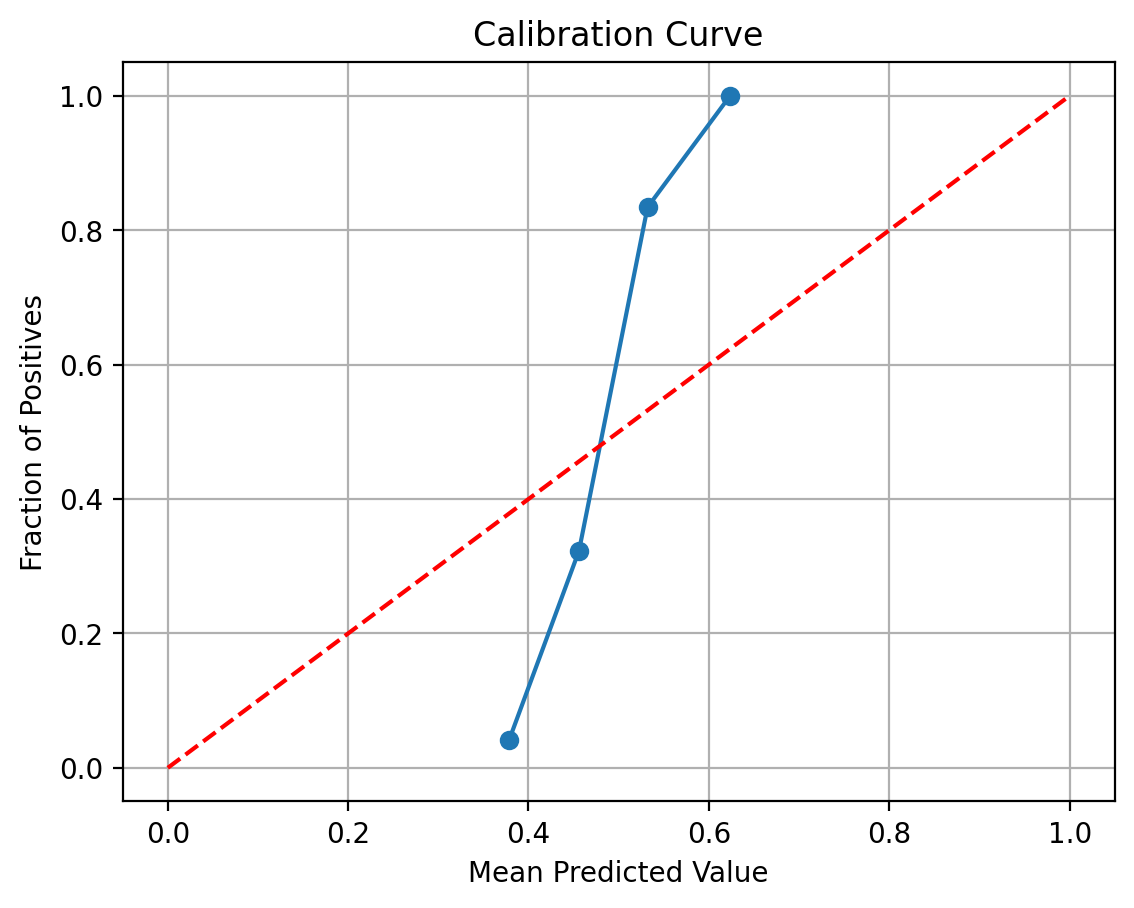

In [35]:
prob_true, prob_pred = compute_calibration_curve(true_labels, predicted_prob)

In [36]:
ece_densenet = computeECE(true_labels, prob_true, prob_pred)


============= Expected Calibration Error (ECE) =============
0.2871


#### We add now Platt scaling

In [37]:
# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]

#### Compute the Accuracy

In [38]:
acc_densenet_plat_05 = compute_plat_accuracy(platt_scaled_probs, true_labels, threshold= 0.5)


============= Accuracy after Platt scaling (Confidence=0.500000) =============
0.7785


In [39]:
acc_densenet_plat_075 = compute_plat_accuracy(platt_scaled_probs, true_labels, threshold= 0.75)


============= Accuracy after Platt scaling (Confidence=0.750000) =============
0.7095


As we increase the decission confidence, the accuracy is reduced, but we obtain better results in this way, by applying the Platt Scaling


============= True labels =============
[0.05533597 0.12820513 0.20670391 0.33928571 0.48125    0.54819277
 0.67539267 0.79       0.87665198 0.90540541]

============= Predicted Probabilities =============
[0.05437729 0.1464414  0.2497171  0.34993417 0.44819815 0.54851253
 0.65207599 0.74999834 0.85236788 0.94904734]


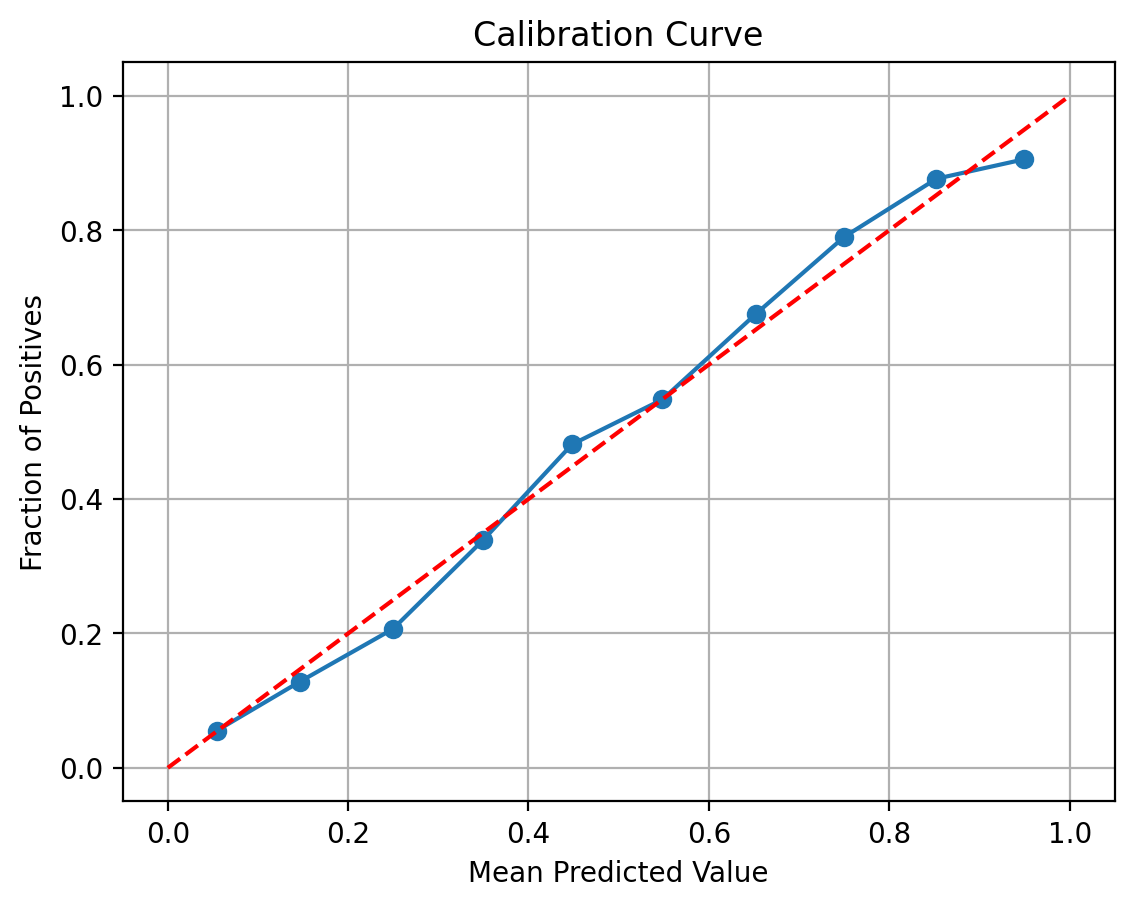

In [40]:
prob_true, prob_pred = compute_calibration_curve(true_labels, platt_scaled_probs)

In [41]:
ece_densenet_plat = computeECE(true_labels, prob_true, prob_pred)


============= Expected Calibration Error (ECE) =============
0.0237


## Checking our results

In [55]:
#given all the ece and accuracy values, i want to make a table and check them all together

import pandas as pd

data = {'Model': ['LeNet5', 'LeNet5 Regu', 'LeNet5 Regu+Platt (Conf=0.5)',
                  'LeNet5 Regu+Platt (Conf=0.75)', 'DenseNet121', 
                  'DenseNet+Platt (Conf=0.5)', 'DenseNet+Platt (Conf=0.75)'],

        'Accuracy': [accuracy_lenet5, accuracy_lenet5_regu, accuracy_lenet5_regu_plat_05, accuracy_lenet5_regu_plat_075,
                     accuracy_densenet, acc_densenet_plat_05, acc_densenet_plat_075],

        'ECE': [ece_lenet5, ece_lenet5_regu, ece_lenet5_regu_plat, ece_lenet5_regu_plat, ece_densenet, ece_densenet_plat, ece_densenet_plat]}

df = pd.DataFrame(data)

print(df)



                           Model  Accuracy       ECE
0                         LeNet5    0.7905  0.160234
1                    LeNet5 Regu    0.7825  0.043941
2   LeNet5 Regu+Platt (Conf=0.5)    0.7905  0.040554
3  LeNet5 Regu+Platt (Conf=0.75)    0.7650  0.040554
4                    DenseNet121    0.7585  0.287086
5      DenseNet+Platt (Conf=0.5)    0.7785  0.023747
6     DenseNet+Platt (Conf=0.75)    0.7095  0.023747


### Comparison of the Accuracy

/tmp/ipykernel_100404/851904081.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', linewidth=0.5) for i in range(len(legend_labels))]


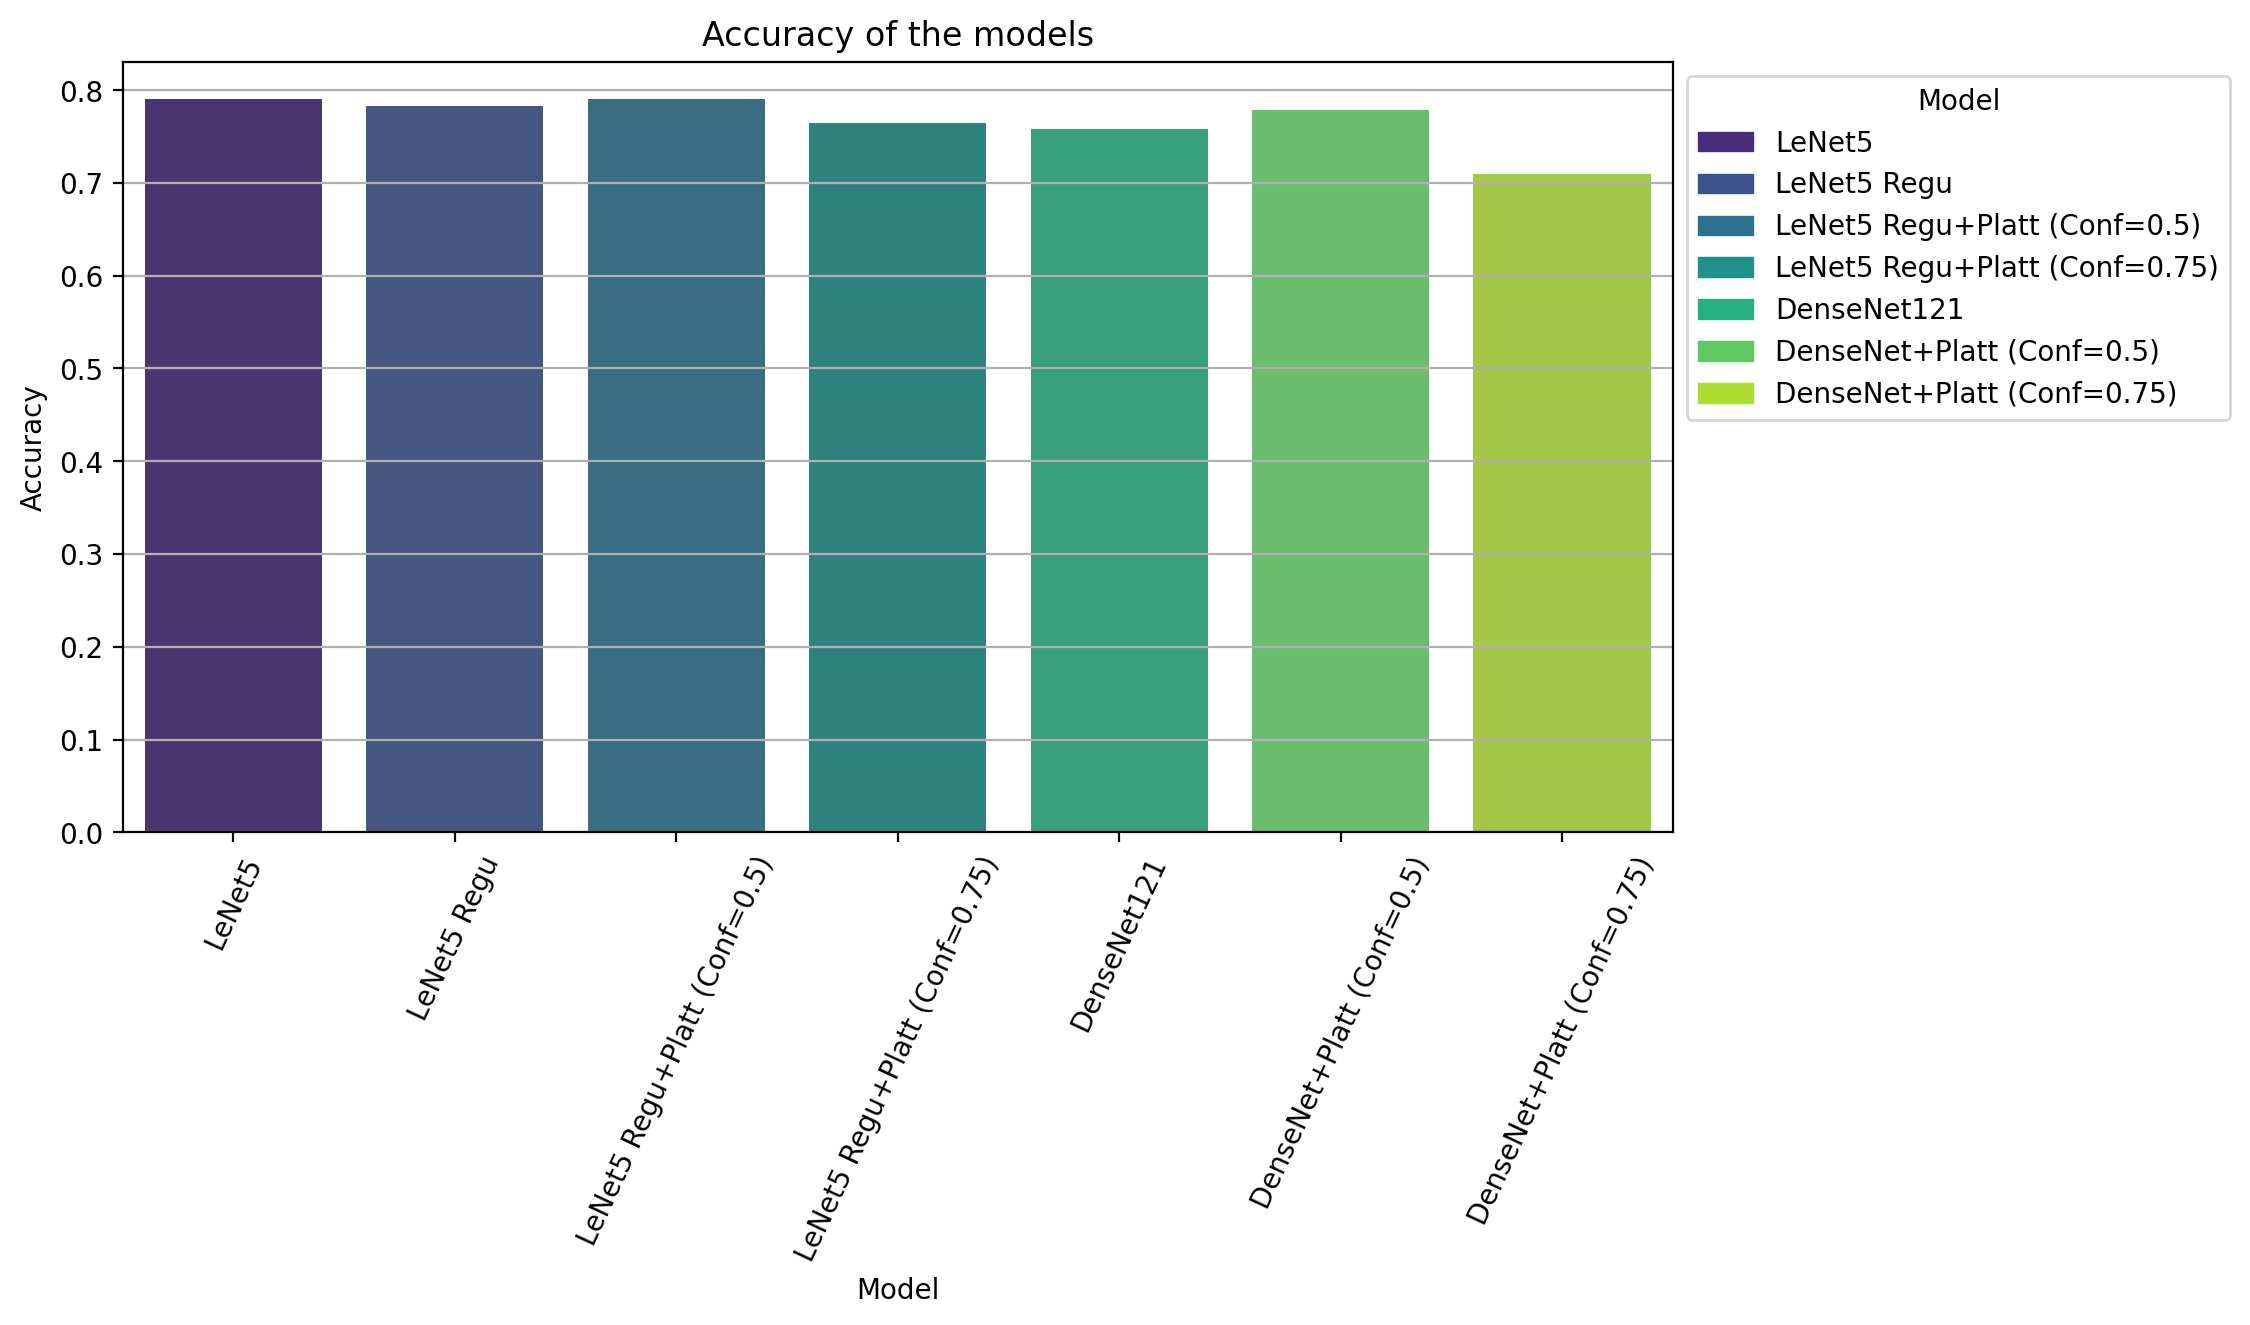

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')
plt.xticks(rotation=65)
plt.title('Accuracy of the models')
plt.grid(axis='y')  # Display grid lines only along the y-axis

# Creating legend with corresponding colors
legend_labels = df['Model'].unique()
colors = sns.color_palette('viridis', len(legend_labels))
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', linewidth=0.5) for i in range(len(legend_labels))]
legend = ax.legend(legend_handles, legend_labels, title="Model", bbox_to_anchor=(1, 1), loc='upper left')

plt.show()


### Comparison of the ECE

/tmp/ipykernel_100404/1097690977.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', linewidth=0.5) for i in range(len(legend_labels))]


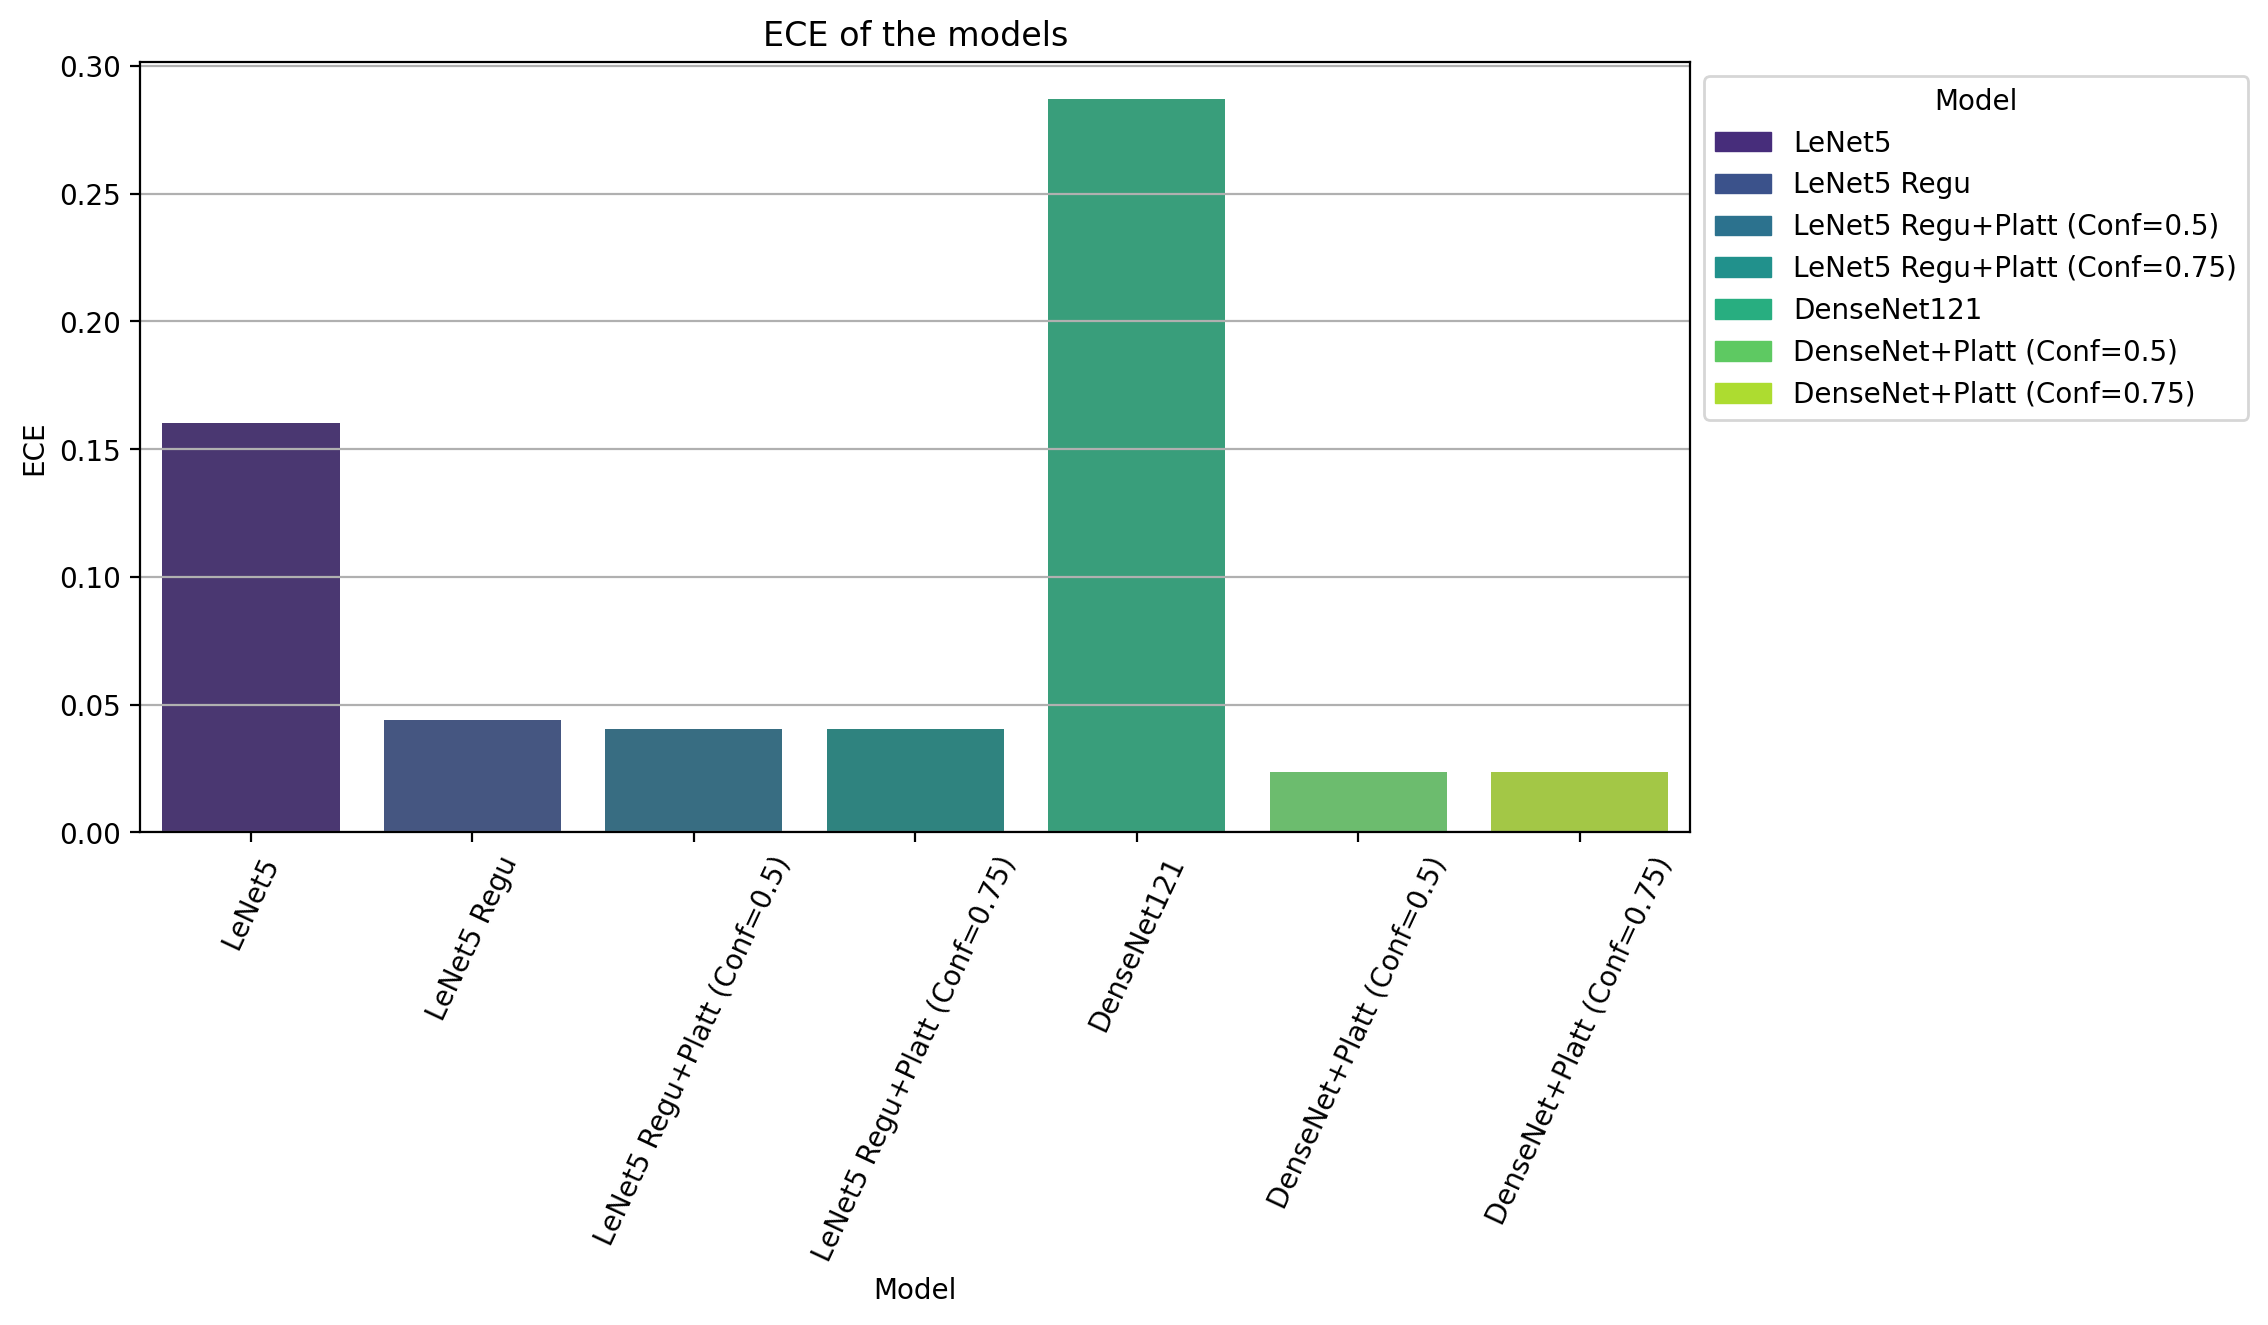

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='ECE', data=df, palette='viridis')
plt.xticks(rotation=65)
plt.title('ECE of the models')
plt.grid(axis='y')  # Display grid lines only along the y-axis

# Creating legend with corresponding colors
legend_labels = df['Model'].unique()
colors = sns.color_palette('viridis', len(legend_labels))
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', linewidth=0.5) for i in range(len(legend_labels))]
legend = ax.legend(legend_handles, legend_labels, title="Model", bbox_to_anchor=(1, 1), loc='upper left')

plt.show()
